In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory, plot_tools

In [2]:
def simulate_LIF_neuron(input_current,
                        simulation_time=2* b2.ms,
                        v_rest=-70*b2.mV,
                        v_reset=-70*b2.mV,
                        firing_threshold=-50*b2.mV,
                        membrane_resistance=10*b2.Mohm,
                        membrane_time_scale=20*b2.ms,
                        abs_refractory_period=5*b2.ms,
                        neuron_amp = 10*b2.mV,
                        neuron_freq = 5*b2.Hz,
                        neuron_phase = 2*b2.pi):
 
    # differential equation of Phase-Locked Leaky Integrate-and-Fire model
    pi = b2.pi
    eqs = """
    dv/dt =
    ( -(v-v_rest) + membrane_resistance * input_current(t,i) + neuron_amp * sin(2*pi * t * neuron_freq + neuron_phase)) / membrane_time_scale : volt (unless refractory)"""

    # LIF neuron using Brian2 library
    neuron = b2.NeuronGroup(
        1, model=eqs, reset="v=v_reset", threshold="v>firing_threshold",
        refractory=abs_refractory_period, method="euler")

    neuron.v = v_rest  # set initial value

    # monitoring membrane potential of neuron and injecting current
    state_monitor = b2.StateMonitor(neuron, ["v"], record=True)
    spike_monitor = b2.SpikeMonitor(neuron)
    # run the simulation
    b2.run(simulation_time)

    # calculate the firing rate in Hz
    fr = spike_monitor.num_spikes/simulation_time

	# # calculate coefficient of variation
    ISIs = spike_monitor.spike_trains()[0][1:]-spike_monitor.spike_trains()[0][:-1]
    cv = np.std(ISIs)/np.mean(ISIs)

    return state_monitor, spike_monitor, fr, cv


In [3]:
def plot_voltage_and_current_traces(voltage_monitor, current, title=None, firing_threshold=None, legend_location=0):
    """plots voltage and current .

    Args:
        voltage_monitor (StateMonitor): recorded voltage
        current (TimedArray): injected current
        title (string, optional): title of the figure
        firing_threshold (Quantity, optional): if set to a value, the firing threshold is plotted.
        legend_location (int): legend location. default = 0 (="best")

    Returns:
        the figure
    """

    assert isinstance(voltage_monitor, b2.StateMonitor), "voltage_monitor is not of type StateMonitor"
    assert isinstance(current, b2.TimedArray), "current is not of type TimedArray"

    time_values_ms = voltage_monitor.t / b2.ms

    # current
    axis_c = plt.subplot(211)
    c = current(voltage_monitor.t, 0)
    max_current = max(current(voltage_monitor.t, 0))
    min_current = min(current(voltage_monitor.t, 0))
    margin = 1.05 * (max_current - min_current)
    # plot the input current time-aligned with the voltage monitor
    plt.plot(voltage_monitor.t / b2.ms, c, "r", lw=2)
    if margin > 0.:
        plt.ylim((min_current - margin) / b2.amp, (max_current + margin) / b2.amp)
    # plt.xlabel("t [ms]")
    plt.ylabel("Input current [A] \n min: {0} \nmax: {1}".format(min_current, max_current))
    plt.grid()
    axis_v = plt.subplot(212)
    plt.plot(time_values_ms, voltage_monitor[0].v / b2.mV, lw=2)
    if firing_threshold is not None:
        plt.plot(
            (voltage_monitor.t / b2.ms)[[0, -1]],
            [firing_threshold / b2.mV, firing_threshold / b2.mV],
            "r--", lw=2
        )
    max_val = max(voltage_monitor[0].v)
    if firing_threshold is not None:
        max_val = max(max_val, firing_threshold)
    min_val = min(voltage_monitor[0].v)
    margin = 0.05 * (max_val - min_val)
    plt.ylim((min_val - margin) / b2.mV, (max_val + margin) / b2.mV)
    plt.xlabel("t [ms]")
    plt.ylabel("membrane voltage [mV]\n min: {0}\n max: {1}".format(min_val, max_val))
    plt.grid()

    # if firing_threshold is not None:
    #     plt.legend(["vm", "firing threshold"], fontsize=10, loc=legend_location)
    # x = scipy.signal.correlate(b2.asarray(voltage_monitor.t),b2.asarray(voltage_monitor[0].v))

    if title is not None:
        plt.suptitle(title)
    return axis_c, axis_v

nr of spikes: 1


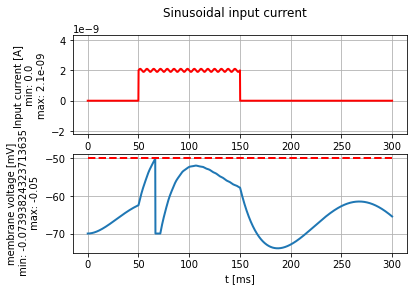

The spike firing rate is 3.3333333333333335 and the CV is nan


In [55]:
# neuron in phase with our input current (entrained/phase-locked)
b2.start_scope()

sinusoidal_current = input_factory.get_sinusoidal_current(500, 1500, unit_time=0.1 * b2.ms, amplitude=20* b2.namp, frequency=150 * b2.Hz, direct_current=2. * b2.namp)

# run the LIF model
(state_monitor, spike_monitor,fr,cv) = simulate_LIF_neuron(input_current=sinusoidal_current, simulation_time=300* b2.ms, neuron_freq = 5*b2.Hz, neuron_phase = 2*b2.pi)

axis_c, axis_v = plot_voltage_and_current_traces(state_monitor, sinusoidal_current, title="Sinusoidal input current", firing_threshold=-50*b2.mV)
print("nr of spikes: {}".format(spike_monitor.count[0]))
plt.show()
print(f'The spike firing rate is {fr} and the CV is {cv}')

In [ ]:
# neuron out of phase with our input current
b2.start_scope()

sinusoidal_current = input_factory.get_sinusoidal_current(500, 1500, unit_time=0.1 * b2.ms, amplitude=20* b2.namp, frequency=150 * b2.Hz, direct_current=2. * b2.namp)

# run the LIF model
(state_monitor, spike_monitor,fr,cv) = simulate_LIF_neuron(input_current=sinusoidal_current, simulation_time=300* b2.ms, neuron_freq = 5*b2.Hz, neuron_phase = 3.14)

plot_voltage_and_current_traces(state_monitor, sinusoidal_current, title="Sinusoidal input current", firing_threshold=-50*b2.mV, legend_location = 'best')
print("nr of spikes: {}".format(spike_monitor.count[0]))
plt.show()
print(f'The spike firing rate is {fr} and the CV is {cv}')

In [52]:
sinusoidal_current = input_factory.get_sinusoidal_current(500, 1500, unit_time=0.1 * b2.ms, amplitude=20* b2.namp, frequency=150 * b2.Hz, direct_current=2. * b2.namp)
n_vals = []
spikes = []
for x in np.linspace(2*b2.Hz,12*b2.Hz,10):
    b2.start_scope()
    # run the LIF model
    (state_monitor, spike_monitor,fr,cv) = simulate_LIF_neuron(input_current=sinusoidal_current, simulation_time=300* b2.ms, neuron_freq = x, neuron_phase = 2*b2.pi)
    n_vals.append(x/b2.Hz)
    spikes.append(spike_monitor.count[0])
